# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# Preprocessing 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import seaborn as sns
import warnings
import math
import progressbar

warnings.filterwarnings("ignore")
sns.set()
bar = progressbar.ProgressBar(maxval=100, \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

* Loading Data from sql database. Ignored neutral reviews that is score=3. And data is sorted according to time.

In [2]:
import sqlite3

conn = sqlite3.connect('Data/database.sqlite')

data = pd.read_sql_query("select * from Reviews where Score !=3 order by Time", conn)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


### Deduplication


* Same review from a user to a product in different time indicates duplicate data.
* Removed data that has same product ID, user id, score, text values.

In [3]:
# removing duplicates
data = data.drop_duplicates(subset={'ProductId', 'UserId', 'Score', 
                            'Text'}, keep='first')

### Data Cleaning

* Removed html tags, punctuations from each sentence.
* Each word is lowercased and removed stop words(a, an, the....).
* Considered score 1 and 2 as negative review and scores 4 and 5 are considered as positive review.
* For negative review '0' as label and for positive review '1' as label.

In [4]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

stop_words = set(stopwords.words('english'))
snow = SnowballStemmer('english')
pre_processed = []

i = 0
bar.maxval = len(data['Text'])
bar.start()
for sentence in data['Text']:    
    sentence = str(sentence)
    sentence = sentence.lower()
    clnr = re.compile('<.*?>') # for cleaning html tags
    sentence = re.sub(clnr, ' ', sentence)
    sentence = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]', r' ', sentence)
    sentence = re.sub('</br>', ' ', sentence) # br tag
    sentence = re.sub('\s+',' ', sentence)
    
    words = [snow.stem(word) for word in sentence.split() \
             if word not in stop_words]
    final_sentence = ''
    for word in words:
        final_sentence = final_sentence + word + ' '
    pre_processed.append(final_sentence)
    bar.update(i)
    i += 1

data['Text'] = pre_processed
bar.finish()

[========================================================================] 100%


### Data Segmentation

* First 5k review taken into consideration.
* Taken only text column from data.
* Data is divided according to time.

In [5]:
data = data['Text'][0:10000]

# Bag of Words

* Trained bag of words by using training data. Transformed training and testing data to numerical vectors.
* Considered only top most 1000 important words.
* Each sentence is converted into a vector of size 1000.

In [6]:
# Training Bag of words
from sklearn.feature_extraction.text import CountVectorizer

bow_model = CountVectorizer(max_features=1000)
bow_data = bow_model.fit_transform(data)

## Agglomerative Clustering

* Technique for clustering data points in hierarchical clustering. 
* Clustered using AgglomerativeClustering from sklearn.cluster module.
* Trained on bag of words data.

Calculating 5 clusters.

In [7]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=5)
agglomerative.fit(bow_data.toarray())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [8]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

D = pairwise_distances(bow_data)
performence = []
performence.append([5, silhouette_score(D, agglomerative.labels_)])

Labelling each sentence to their respective cluster number and saving each cluster data into text data to read manually.

In [9]:
# loading not preprocessed data
import sqlite3

conn = sqlite3.connect('Data/database.sqlite')
original_data = pd.read_sql_query("select * from Reviews where Score !=3 order by Time", conn)

# removing duplicates
original_data = original_data.drop_duplicates(subset={'ProductId', 'UserId', 'Score', 
                            'Text'}, keep='first')

In [10]:
labels = agglomerative.labels_
cluster_data = [[] for i in range(5)]

i = 0
for label in labels:
    cluster_data[label].append(original_data['Text'].iloc[i])
    i += 1

In [11]:
# saving 2nd cluster data into text file
with open('Saved/cluter2.txt', 'w') as f:
    for sentence in cluster_data[1]:
        f.write(sentence)
        f.write('\n')

* Its observed that in 2nd cluster review are postive reviews about random products.

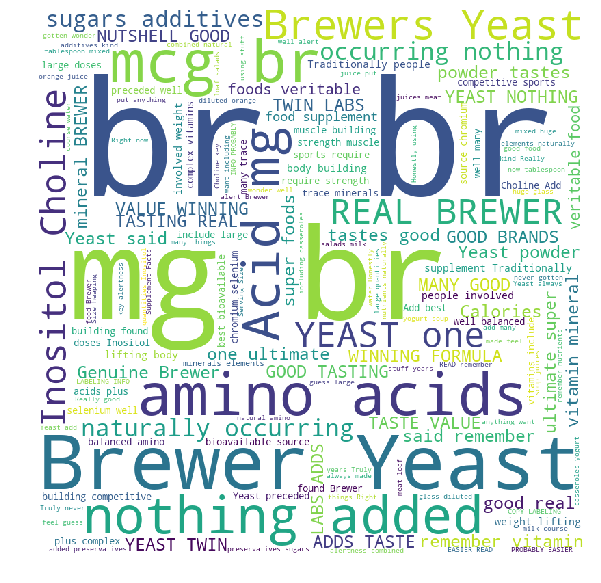

In [12]:
# 5th cluster wordcloud
from wordcloud import WordCloud
dt = ' '
for sen in cluster_data[4]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

Calculating 10 clusters.

In [13]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=10)
agglomerative.fit(bow_data.toarray())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=10,
            pooling_func='deprecated')

In [14]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

D = pairwise_distances(bow_data)
performence.append([10, silhouette_score(D, agglomerative.labels_)])

Labelling each sentence to their respective cluster number and saving each cluster data into text data to read manually.

In [15]:
labels = agglomerative.labels_
cluster_data = [[] for i in range(10)]

i = 0
for label in labels:
    cluster_data[label].append(original_data['Text'].iloc[i])
    i += 1

In [16]:
# saving 4th cluster data into text file
with open('Saved/cluter4.txt', 'w') as f:
    for sentence in cluster_data[3]:
        f.write(sentence)
        f.write('\n')

* Its observed that in 2nd cluster review are postive reviews about random products.

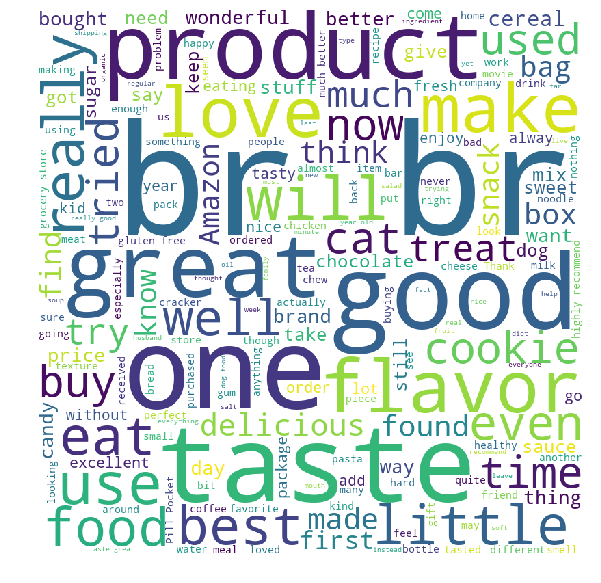

In [17]:
# 5th cluster wordcloud
from wordcloud import WordCloud
dt = ' '
for sen in cluster_data[4]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

# Tf-Idf

* Trained tf-idf by using training data. Transformed training and testing data to numerical vectors.
* TfidfVectorizer from sklearn is used.
* Considered only top most 2000 important words.
* Each sentence is converted into a vector of size 2000.

In [19]:
# Training tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(max_features=2000)
tfidf_data = tfidf_model.fit_transform(data)

## Agglomerative Clustering

* Technique for clustering data points in hierarchical clustering. 
* Clustered using AgglomerativeClustering from sklearn.cluster module.
* Trained on tfidf data.

Calculating 5 clusters.

In [20]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=5)
agglomerative.fit(tfidf_data.toarray())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [21]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

D = pairwise_distances(tfidf_data)
performence = []
performence.append([5, silhouette_score(D, agglomerative.labels_)])

Labelling each sentence to their respective cluster number and saving each cluster data into text data to read manually.

In [22]:
labels = agglomerative.labels_
cluster_data = [[] for i in range(5)]

i = 0
for label in labels:
    cluster_data[label].append(original_data['Text'].iloc[i])
    i += 1

In [23]:
# saving 1st cluster data into text file
with open('Saved/cluter1.txt', 'w') as f:
    for sentence in cluster_data[0]:
        f.write(sentence)
        f.write('\n')

- Most of the reviews contain about movies, books.

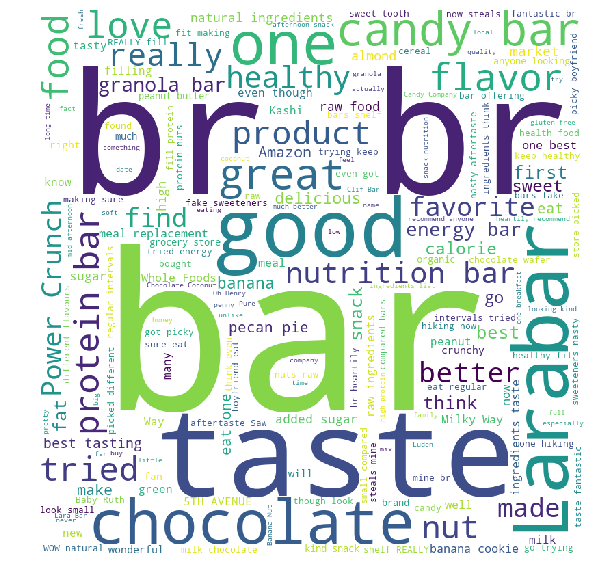

In [24]:
# 5th cluster wordcloud
from wordcloud import WordCloud
dt = ' '
for sen in cluster_data[4]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

Calculating 15 clusters.

In [25]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=15)
agglomerative.fit(tfidf_data.toarray())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=15,
            pooling_func='deprecated')

In [26]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

D = pairwise_distances(tfidf_data)
performence.append([15, silhouette_score(D, agglomerative.labels_)])

Labelling each sentence to their respective cluster number and saving each cluster data into text data to read manually.

In [27]:
labels = agglomerative.labels_
cluster_data = [[] for i in range(15)]

i = 0
for label in labels:
    cluster_data[label].append(original_data['Text'].iloc[i])
    i += 1

In [28]:
# saving 11th cluster data into text file
with open('Saved/cluter11.txt', 'w') as f:
    for sentence in cluster_data[10]:
        f.write(sentence)
        f.write('\n')

* 11th cluster has one single sentence review.

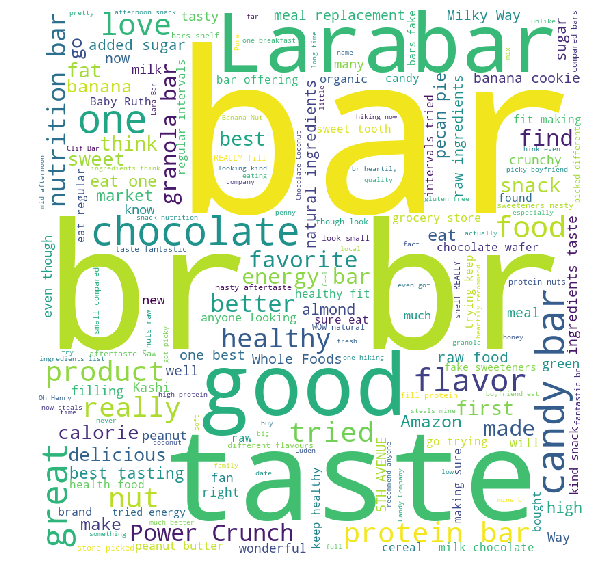

In [29]:
# 5th cluster wordcloud
from wordcloud import WordCloud
dt = ' '
for sen in cluster_data[4]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

# Word2vec

* Trained own word2vec using gensim module. Considered words which has frequency more than 5 in whole data.
* Trained word2vec using Word2vec function from gensim.models.
* Trained for vector of size 150. And converted each word into a vector of size 150.
* Added all vectors of a sentence and divided with total number of vectors in sentence. So that we can get average word2vec value for each sentence.m

In [31]:
# training word2vec on training data
from gensim.models import Word2Vec
sentences = []
for row in data:
    sentences.append([word for word in row.split()])

w2v = Word2Vec(sentences, min_count=5, size=150, workers=3)
avgw2v_data = []
for row in sentences:
    te = [0 for i in range(150)]
    num = 0
    for word in row:
        try:
            te += w2v[word]
            num += 1
        except:
            pass
    avgw2v_data.append(te/num)

## Agglomerative Clustering

* Technique for clustering data points in hierarchical clustering. 
* Clustered using AgglomerativeClustering from sklearn.cluster module.
* Trained on average word2vec data.

Calculating 5 clusters.

In [32]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=5)
agglomerative.fit(avgw2v_data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [33]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

D = pairwise_distances(avgw2v_data)
performence = []
performence.append([5, silhouette_score(D, agglomerative.labels_)])

Labelling each sentence to their respective cluster number and saving each cluster data into text data to read manually.

In [34]:
labels = agglomerative.labels_
cluster_data = [[] for i in range(5)]

i = 0
for label in labels:
    cluster_data[label].append(original_data['Text'].iloc[i])
    i += 1

In [35]:
# saving 2nd cluster data into text file
with open('Saved/cluter2.txt', 'w') as f:
    for sentence in cluster_data[1]:
        f.write(sentence)
        f.write('\n')

* Its observed that in 2nd cluster review has few number of reviews. And all reviews about either tea or starbuks.

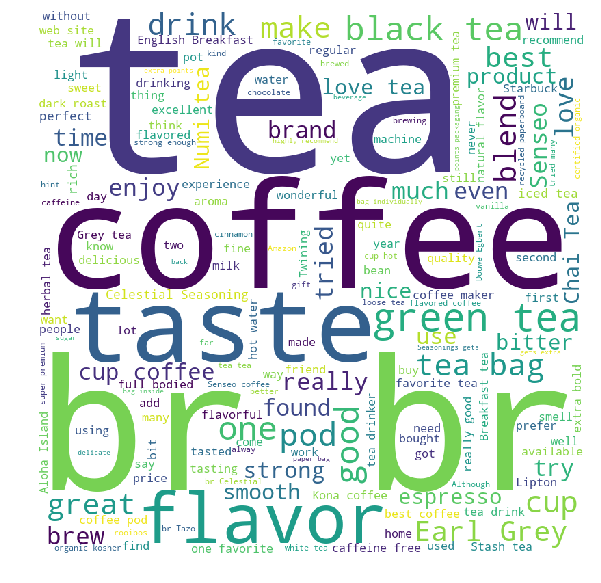

In [36]:
# 2th cluster wordcloud
from wordcloud import WordCloud
dt = ' '
for sen in cluster_data[1]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

Calculating 20 clusters.

In [37]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=20)
agglomerative.fit(avgw2v_data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=20,
            pooling_func='deprecated')

In [38]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

D = pairwise_distances(avgw2v_data)
performence.append([20, silhouette_score(D, agglomerative.labels_)])

Labelling each sentence to their respective cluster number and saving each cluster data into text data to read manually.

In [39]:
labels = agglomerative.labels_
cluster_data = [[] for i in range(20)]

i = 0
for label in labels:
    cluster_data[label].append(original_data['Text'].iloc[i])
    i += 1

In [40]:
# saving 13th cluster data into text file
with open('Saved/cluter13.txt', 'w') as f:
    for sentence in cluster_data[12]:
        f.write(sentence)
        f.write('\n')

* Its observed that in 13th cluster contain reviews about chocolates.

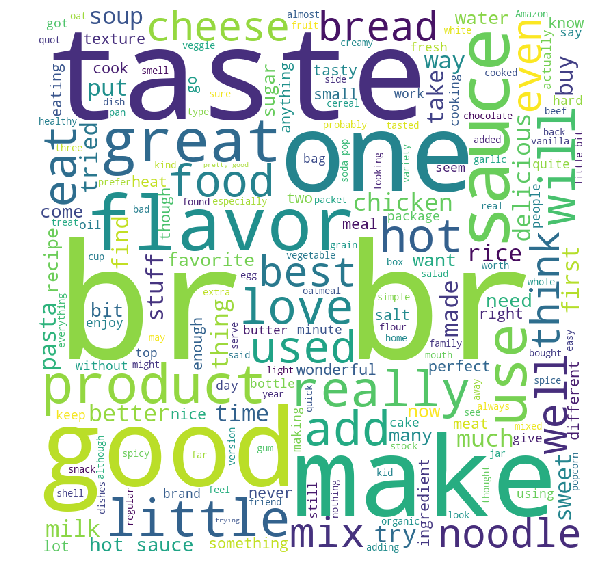

In [41]:
# 15th cluster wordcloud
from wordcloud import WordCloud
dt = ' '
for sen in cluster_data[14]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

# Tf-IDF word2vec

* Using pre-trained tf-idf vectors and word2vec of size 150.
* Multiplying each word's word2vec vector and tf-idf value of that word in respected sentence.
* Executing above step for each word in a sentence and took sum of values of all words in a sentence.
* And this sum is divided by sum of tf-idf values of all words in sentences. Finally gives tf-idf word2vec values of size 150 for each sentence.

In [43]:
tfidf_data = tfidf_data.toarray()

In [44]:
sentences = []
for row in data:
    sentences.append([word for word in row.split()])

tfidfw2v_data = []
i = 0
for row in sentences:
    te = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tfidf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    num = 0
    tf_idf_sum = 0
    for word in row:
        try:
            num += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[num-1]
            te += (temp_tfidf[num-1] * w2v[word])
        except:
            pass
    try: # avoiding divide by zero
        te = (float)(1/tf_idf_sum) * te
    except:
        pass
    tfidfw2v_data.append(te)
    i = i + 1

## Agglomerative Clustering

* Technique for clustering data points in hierarchical clustering. 
* Clustered using AgglomerativeClustering from sklearn.cluster module.
* Trained on tfidf word2vec data.

Calculating 5 clusters.

In [45]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=5)
agglomerative.fit(tfidfw2v_data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [46]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

D = pairwise_distances(tfidfw2v_data)
performence = []
performence.append([5, silhouette_score(D, agglomerative.labels_)])

Labelling each sentence to their respective cluster number and saving each cluster data into text data to read manually.

In [47]:
labels = agglomerative.labels_
cluster_data = [[] for i in range(5)]

i = 0
for label in labels:
    cluster_data[label].append(original_data['Text'].iloc[i])
    i += 1

In [48]:
# saving 5th cluster data into text file
with open('Saved/cluter5.txt', 'w') as f:
    for sentence in cluster_data[4]:
        f.write(sentence)
        f.write('\n')

* In this cluster either cat or dog is mentioned in every review.

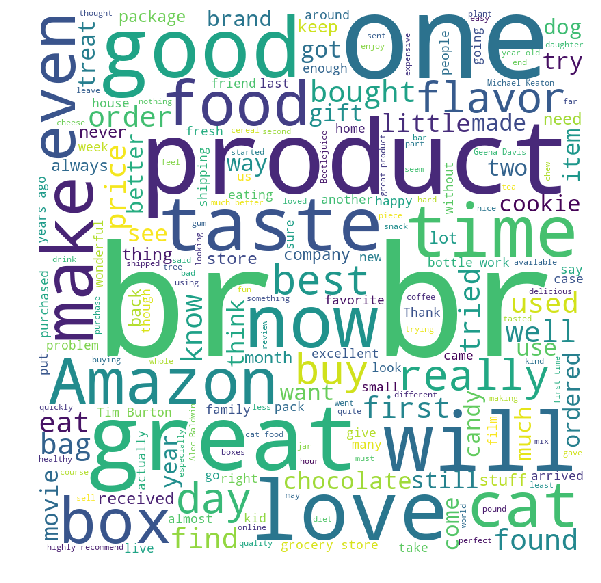

In [49]:
# 1st cluster wordcloud
from wordcloud import WordCloud
dt = ' '
for sen in cluster_data[0]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

Calculating 10 clusters.

In [50]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=10)
agglomerative.fit(tfidfw2v_data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=10,
            pooling_func='deprecated')

In [51]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

D = pairwise_distances(tfidfw2v_data)
performence.append([10, silhouette_score(D, agglomerative.labels_)])

Labelling each sentence to their respective cluster number and saving each cluster data into text data to read manually.

In [52]:
labels = agglomerative.labels_
cluster_data = [[] for i in range(10)]

i = 0
for label in labels:
    cluster_data[label].append(original_data['Text'].iloc[i])
    i += 1

In [53]:
# saving 9th cluster data into text file
with open('Saved/cluter9.txt', 'w') as f:
    for sentence in cluster_data[8]:
        f.write(sentence)
        f.write('\n')

* This cluster have normal reviews about random products.

# Conclusion

In [18]:
print("Heirachical Clustering with bag of words: ")
from prettytable import PrettyTable

tb = PrettyTable()
tb.field_names = ['n_clusters', 'silhouette_score']
tb.add_row(performence[0])
tb.add_row(performence[1])
print(tb)

Heirachical Clustering with bag of words: 
+------------+---------------------+
| n_clusters |   silhouette_score  |
+------------+---------------------+
|     5      |  0.6212930754214496 |
|     10     | 0.09820169544001602 |
+------------+---------------------+


In [30]:
print("Heirachical Clustering with tfidf: ")
from prettytable import PrettyTable

tb = PrettyTable()
tb.field_names = ['n_clusters', 'silhouette_score']
tb.add_row(performence[0])
tb.add_row(performence[1])
print(tb)

Heirachical Clustering with tfidf: 
+------------+---------------------+
| n_clusters |   silhouette_score  |
+------------+---------------------+
|     5      | 0.07817804840470294 |
|     15     | 0.05916735067416105 |
+------------+---------------------+


In [42]:
print("Heirachical Clustering with average word2vec: ")
from prettytable import PrettyTable

tb = PrettyTable()
tb.field_names = ['n_clusters', 'silhouette_score']
tb.add_row(performence[0])
tb.add_row(performence[1])
print(tb)

Heirachical Clustering with average word2vec: 
+------------+-----------------------+
| n_clusters |    silhouette_score   |
+------------+-----------------------+
|     5      |  0.10265837925045393  |
|     20     | -0.001572873416995421 |
+------------+-----------------------+


In [54]:
print("Heirachical Clustering with tfidf word2vec: ")
from prettytable import PrettyTable

tb = PrettyTable()
tb.field_names = ['n_clusters', 'silhouette_score']
tb.add_row(performence[0])
tb.add_row(performence[1])
print(tb)

Heirachical Clustering with tfidf word2vec: 
+------------+----------------------+
| n_clusters |   silhouette_score   |
+------------+----------------------+
|     5      |  0.0945938649193499  |
|     10     | 0.040594894163907644 |
+------------+----------------------+


* Bag of words with 5 number of clusters gave best silhoutte score.